### 人脸检测：Haar特征分类器和级联分类器
以Haar特征分类器为基础的对象检测是一种非常有效地对象检测技术，多用于人脸、行人检测。Haar-like是cv中常用的特征描述算子，也称为Harr特征。Haar特征就是用下图中黑色矩形所有像素值的和减去白色矩形所有像素值的和。
<center><img src="pic/haar1.png" alt="FAO" width="500"></center> 

Haar特征可以在检测窗口中由放大+平移产生一系列子特征。在论文《Rapid Object Detection using a Boosted Cascade of Simple Features》中，作者使用的检测器设定为24*24的大小，得到了超过180000个特征。  

<center><img src="pic/haar2.jpeg" alt="FAO" width="500"></center> 

Haar特征值反映了图像的灰度变化情况，实验证明可以将极少数的特征结合起来，形成有效的分类器。例如：脸部的一些特征能由矩形特征简单的描述，如：眼睛要比脸颊颜色要深，鼻梁两侧比鼻梁颜色要深，嘴巴比周围颜色要深等。为了达到这个目的，我们将每一个特征应用于所有的训练图像（正样本人脸图像，负样本非人脸图像）。我们要选取错误率最低的特征，这说明它们是检测面部和非面部图像最好的特征。作者最终从180000个特征中选择了6061个特征。  

<center><img src="pic/haar3.png" alt="FAO" width="400"></center> 

为了找到图像中不同位置的目标，需要逐次移动检测窗口（窗口中的Haar特征相应也随着移动），这样就可以遍历到图像中的每一个位置。而为了检测到不同大小的目标，一般有两种做法：逐步缩小图像或者逐步放大检测窗口，这样即可遍历到图像中不同大小的目标。  

<center><img src="pic/haar4.jpeg" alt="FAO" width="500"></center> 

如果对每一个24x24的窗口使用这6061个特征来做检查，看它是不是面部，会比较耗时，所以最好有一个简单的方法来证明这个窗口不是面部区域，如果不是就直接抛弃，不用对它再做处理。为了达到这个目的作者提出了级联分类器的概念。    
    
不是在一开始就对窗口进行这6061个特征测试，将这些特征分成不同组。在不同的分类阶段逐个使用。通常前面很少的几个阶段使用较少的特征检测。研究发现分类器判断不是人脸的正确率很高，判断是人脸的正确率一般。如果一个窗口第一阶段的检测都过不了就可以直接放弃后面的测试了，如果它通过了就进入第二阶段的检测。如果一个窗口经过了所有的测试，那么这个窗口就被认为是面部区域。  
    
作者将6061多个特征分为38个阶段，前五个阶段的特征数分别为1，10，25，25和50。剩下的各层包含的特征数量急剧增多。特征总数是6061个。

<center><img src="pic/haar5.png" alt="FAO" width="500"></center> 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def show(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
def imread(image):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [2]:
# 级联分类器
def facedetect(image):
    detector = cv2.CascadeClassifier('C:/Users/kljdgf/AppData/Local/Programs/Python/Python36/Lib/site-packages/cv2/data/haarcascade_frontalface_alt.xml')    # 用于人脸识别的haar特征文件
    rects = detector.detectMultiScale(image,
                                    scaleFactor=1.1,    # 每次缩小的图像比例，默认为1.1
                                    minNeighbors=3, # 匹配成功所需要的周围矩形框的数目，只有多个矩形框同时存在时，才认为匹配成功，人脸识别中，默认值为3
                                    minSize=(10,10),    # 匹配人脸的最小范围
                                    flags=cv2.CASCADE_SCALE_IMAGE
                                       )
#     print(rects)    # [[165 42 179 179]]
    for (x,y,w,h) in rects:    # 检测到几个人脸就画几个框
        cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 2)
    show(image)

# flags=0：可以取如下这些值：  
# CASCADE_DO_CANNY_PRUNING=1, 利用canny边缘检测来排除一些边缘很少或者很多的图像区域  
# CASCADE_SCALE_IMAGE=2, 正常比例检测  
# CASCADE_FIND_BIGGEST_OBJECT=4, 只检测最大的物体  
# CASCADE_DO_ROUGH_SEARCH=8 初略的检测 

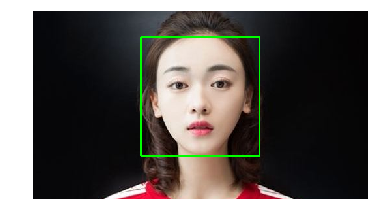

In [3]:
image = imread('./image/face.png')
# show(image)
facedetect(image)

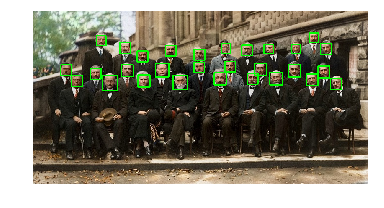

In [4]:
image = imread('./image/Solvay.jpg')
facedetect(image)

### 10.2 使用opencv做人脸识别

In [5]:
import os
import imghdr

######  第一步：采集人脸样本

In [6]:
def facedetect(image, output):
    '''
    人脸检测并保存人脸
    output: 检测出人脸的图片将要保存的位置
    '''
    # 获取文件名
    name = os.path.basename(image)
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 级联分类器，检测人脸
    detector = cv2.CascadeClassifier('C:/Users/kljdgf/AppData/Local/Programs/Python/Python36/Lib/site-packages/cv2/data/haarcascade_frontalface_alt.xml')
    rects = detector.detectMultiScale(image, scaleFactor=1.1, minNeighbors=3, minSize=(10,10), flags=cv2.CASCADE_SCALE_IMAGE)
    # 循环每个人脸
    for (x,y,w,h) in rects:
#         cv2.rectangle(rects, (x,y), (x+w,y+h), (0,255,0), 2)
        # 不画框，截取人脸，并设定大小都为200*200
        f = cv2.resize(image[y:y+h, x:x+w], (200,200))
        cv2.imwrite(os.path.join(output, name), f)
        
def predict_face(path, output):
    '''
    检测并截取人脸
    path: 样本所在文件夹；output: 输出的文件夹
    主要是先把图片的路径和存放位置先确定好
    '''
    if not os.path.exists(output):
        os.makedirs(output)
    # 循环每个人物文件夹下的图片
    for files in os.listdir(path):
        # 检测是不是文件夹
        if os.path.isdir(os.path.join(path, files)):
            print(os.path.join(path, files))
            # 定义检测到的人脸的输出路径
            output2 = os.path.join(output, files)
            if not os.path.exists(output2):
                os.makedirs(output2)
            # 任务文件夹的完整路径
            files = os.path.join(path, files)
            for file in os.listdir(files):
                file = os.path.join(files, file)
                facedetect(file, output2)

In [8]:
predict_face('face_sample/faces', 'face_sample/predict_faces')

face_sample/faces\anglababy
face_sample/faces\can


error: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


通过查看预测后的文件夹，发现各有一张不是人脸，所以要人工将其删除。（避免其影响后续模型的训练）

###### 第二步：生成label

In [ ]:
def get_label(path):
    fh = open('face_sample/label.txt', 'w')
    label = 0    # 表示人脸
    for root, dirs, files in os.walk(path):
        # 再循环每个文件夹
#         print('root: '+str(root))
#         print('dirs: '+str(dirs))
#         print('files: '+str(files))
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            for file in os.listdir(subdir_path):
                filepath = os.path.join(subdir_path, file)
                # 判断文件类型是否为图片类型
                imgType = imghdr.what(filepath)
                if imgType=='jpeg' or imgType=='png':
                    fh.write(filepath)
                    fh.write(';')
                    fh.write(str(label))
                    fh.write('\n')
            label += 1    # 每个人的标签不一样，从0开始计数
    fh.close()

In [ ]:
get_label('face_sample/predict_faces')

###### 3、训练自己的数据模型

In [ ]:
images = []    # 保存图片数据
labels = []    # 保存标签
fh = open('face_sample/label.txt')
for line in fh:
    arr = line.split(';')
    img = cv2.imread(arr[0], 0)
    images.append(img)
    labels.append(int(arr[1]))
# 定义人脸识别模型
model = cv2.face.EigenFaceRecognizer_create()
# 训练模型
model.train(np.array(images), np.array(labels))
# 保存模型
model.save("face_sample/predict_face_XiaoMing_AB.xml")

###### 6、人脸识别

In [ ]:
# 定义人物名字
name= ['ab','can','others','xiaoming']
# 定义人脸识别模型
model = cv2.face.EigenFaceRecognizer_create()
# 载入训练好的模型
model.read('face_sample/predict_face_XiaoMing_AB.xml')

# 读入测试图片来做测试
for file in os.listdir('face_sample/test'):
    file = os.path.join('face_sample/test', file)
    # 判断文件类型
    imgType = imghdr.what(file)
    if imgType == 'jpeg' or imgType == 'png':
        # 读入图片
        image = imread(file)
        # 变为灰度图
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        # 级联分类器
        detector = cv2.CascadeClassifier("C:/Users/kljdgf/AppData/Local/Programs/Python/Python36/Lib/site-packages/cv2/data/haarcascade_frontalface_alt.xml")
        rects = detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(20, 20), flags=cv2.CASCADE_SCALE_IMAGE)
        # 循环每个人脸
        for (x,y,w,h) in rects:
            # 画矩形框
            cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 2)
            # 人脸识别
            face = cv2.resize(gray[y:y+h,x:x+w], (200,200))
            # 预测人物
            params = model.predict(face)
#             print(params)
            # 写上人物名字
#             if params[0]==1:
#                 print('huang xiaoming')
            cv2.putText(image,name[params[0]],(x,y-20),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
        show(image)

可以看出预测效果不怎么样，性别都没有识别出来，深入可以用RNN进行预测。（见后面代码）

缺点：这种识别结果只能是训练目标那几个，如果来一个新的目标，识别结果还是那些。不对，因为训练集只有那些，可以重新训练一个模型，加入许多生人的图片作为负样本。